In [ ]:

%pip install segmentation-models-pytorch
%pip install pytorch-lightning 
%pip install wandb -qU
%pip install onnx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision import models
from PIL import Image, ImageDraw,ImageOps
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp


import torch
import pandas as pd
import numpy as np
import os
import cv2


import warnings
warnings.filterwarnings('ignore')

import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
import wandb

In [ ]:
torch.cuda.is_available()

# Model Setup

In [18]:
N_EPOCH=10
ENCODER = 'resnet18'
Frozen_Encoder_Flag=True
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['nail']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation


LEARNING_RATE=3.4e-4
BATCH_SIZE=15
LOSS_TYPE='DiceLoss'
MODEL_SAVE_NAME="Unet_resnet18_"
DATASET="inat_raw_data_train327_val115:v0"




   
config={ #model
        "architecture": "Unet",
        "encoder":ENCODER,
        "frozen_encoder":Frozen_Encoder_Flag,
        "encoder_weights":ENCODER_WEIGHTS,
        "classes":CLASSES,
        "activation":ACTIVATION,
        # loss
        "loss":"DiceLoss",
        "metrics":"IoU",
        #optimiser
        "learning_rate": LEARNING_RATE,
        #dataset
        "dataset": DATASET,
        # calculation details
        "epochs": N_EPOCH,
        #device
        "device":DEVICE}

run=wandb.init(project="Card_detection",
           notes="wandb setup",
           config=config,
           tags=ENCODER)




# Get Data

In [ ]:
# dowload data from the wandb
artifact = run.use_artifact('team-invonto/Card_detection/inat_data_train63_val115:v0', type='raw_data')
artifact.download('/tmp/')

import zipfile

def load_data_to_tmp(folder_name):
  zip_ref = zipfile.ZipFile('/tmp/'+folder_name, 'r') #Opens the zip file in read mode
  zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
  zip_ref.close()

load_data_to_tmp('Train.zip')
load_data_to_tmp('Validation.zip')

# Dataset


In [19]:
class CardDataset(Dataset):
    """NailDataset dataset.
    img generator that take file names and selected poligons from csv_file
    """

    def __init__(self, csv_file, root_dir, transform=None, augmentation=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
            nail_dataset[img_number_in_csv][1] -image
            nail_dataset[img_number_in_csv][0] -corresponding mask image 
        """
        self.nail_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return self.nail_frame.shape[0]

    def __getitem__(self, idx):
        file_id=self.nail_frame.iloc[idx]["filename"]
        #"read image"
        img_name = os.path.join(self.root_dir,self.nail_frame.iloc[idx]["filename"])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask_name=os.path.join(self.root_dir,self.nail_frame.iloc[idx]["mask"])
        mask = cv2.imread(mask_name)
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)

            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            image = self.transform['image'](image)
            mask = self.transform['mask'](mask)
    
         
        return image, mask

    
transform_dict = {'image': transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize(mean=[0.5815, 0.5152, 0.4708],
                              std=[0.2582, 0.2503, 0.2452]),]),
                 'mask': transforms.Compose([transforms.ToTensor()])}

# Data loader

In [20]:
n_cpu = os.cpu_count()
print("n_cpu={}".format(n_cpu))


#train
data_path=''
x_train_path='/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/Train/'
y_train_dataloader=('/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/Train/Train_DataLoader.csv')
train_dataset = CardDataset(y_train_dataloader, x_train_path,transform=transform_dict, augmentation=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,num_workers=n_cpu)
print('Number of training samples:', len(train_dataset))

# validation
x_valid_path = os.path.join(data_path, 'Validation/')
y_valid_dataloader = os.path.join(x_valid_path, 'Validation_DataLoader.csv')
valid_dataset = CardDataset(y_valid_dataloader,x_valid_path,transform=transform_dict, augmentation=None)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=n_cpu)
valid_dataset_vis=CardDataset(y_valid_dataloader, x_valid_path)
print('Number of validation samples:', len(valid_dataset))

n_cpu=12
Number of training samples: 63
Number of validation samples: 115


In [21]:
# image,mask=valid_dataset[0]
# plt.imshow(mask.numpy().transpose(1, 2, 0))

# # single batch
# batch_img=next(iter(valid_loader))[0]
# batch_mask=next(iter(valid_loader))[1]
# print(batch_img.shape)
# print(batch_mask.shape)

# Model U-Net
https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

In [22]:
from typing import Any


class CardModel(pl.LightningModule):

    def __init__(self,arch,encoder_name,encoder_weights,learning_rate,frozen_encoder=True):
        super().__init__()
        self.lr=learning_rate
        self.save_hyperparameters()
        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=1,
            #activation='sigmoid'
            )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE,from_logits=True)
        
        if frozen_encoder==True:
            for child in self.model.encoder.children():
                for param in child.parameters():
                    param.requires_grad = False 
                    
                    
    def forward(self, image):
        mask = self.model(image)
        return mask
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)
        
        pred_mask=(output_mask.sigmoid() >= 0.5).float()
        
        

        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        train_batch_dictionary={"tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}
        
        self.training_step_outputs.append(train_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_train_epoch_end(self):
        # aggregate step metics
        outputs=self.training_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image) 
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "train_per_image_iou": per_image_iou,
        #    "train_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.training_step_outputs.clear() 



    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)
        
        pred_mask=(output_mask.sigmoid() >= 0.5).float()
        

        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        validation_batch_dictionary={"loss":loss,
                          "tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}
        
        self.validation_step_outputs.append(validation_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    

    def on_validation_epoch_end(self):
        # aggregate step metics
        outputs= self.validation_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image) 
        #dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "validation_per_image_iou": per_image_iou,
            #"validation_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.validation_step_outputs.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr or self.learning_rate))
    


In [23]:
card_model = CardModel("Unet", ENCODER,ENCODER_WEIGHTS,LEARNING_RATE,frozen_encoder=Frozen_Encoder_Flag)
ModelSummary(card_model,max_depth=1)

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 14.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
3.2 M     Trainable params
11.2 M    Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)

In [26]:
card_model = CardModel("Unet", "resnet34","imagenet",0.05,frozen_encoder=True)


wandb_logger = WandbLogger(project="Card_detection")
trainer = pl.Trainer(max_epochs=N_EPOCH,
                     logger=wandb_logger,
                     log_every_n_steps=1)
trainer.fit(
    model=card_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,)
    


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
3.2 M     Trainable params
21.3 M    Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 4/4 [00:46<00:00, 11.71s/it, v_num=tax5, train_loss_step=0.0406, valid_loss=0.141, validation_per_image_iou=0.761, train_loss_epoch=0.0422, train_per_image_iou=0.902]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:47<00:00, 11.78s/it, v_num=tax5, train_loss_step=0.0406, valid_loss=0.141, validation_per_image_iou=0.761, train_loss_epoch=0.0422, train_per_image_iou=0.902]


In [27]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▇▆▅▃▁▁▁▁
train_loss_step,█▇▇▇▇▇▇▇▆▆▆▅▆▅▆▅▅▅▄▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_per_image_iou,▁▁▁▂▇▇████
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
valid_loss,████▇▅▃▂▁▁
validation_per_image_iou,▁▁▁▁▂▄▅▆██
epoch,9
train_loss_epoch,0.04224
train_loss_step,0.04064
train_per_image_iou,0.91269


In [ ]:
# turn learning rate
# trainer = pl.Trainer(enable_progress_bar=True)
# tuner =pl.tuner.Tuner(trainer)
# lr_finder=tuner.lr_find(card_model,train_loader,mode='exponential',min_lr=1e-5, max_lr=0.1, num_training=20)
# print(lr_finder.results)



# fig = lr_finder.plot(suggest=True)
# suggested_lr = lr_finder.suggestion()
# print("suggested_lr",suggested_lr)
# fig.show()

# save data frame
# pd.DataFrame(lr_finder.results).to_csv("LR_tuning_1e-5_1_exponential.csv")

In [16]:
model = card_model.load_from_checkpoint("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt")

# disable randomness, dropout, etc...
model.eval()
x=torch.zeros((1,3,480,320))
y_hat=model(x)


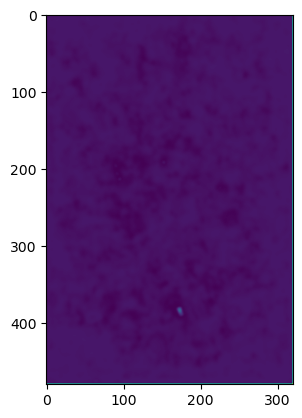

In [28]:
model = card_model.load_from_checkpoint("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt")
model.eval()
x = torch.randn((1,3,480,320))

with torch.no_grad():
    y_hat = model(x)
    plt.imshow(y_hat.numpy().squeeze())

In [24]:
y_hat.detach().numpy().shape

(1, 1, 480, 320)

In [ ]:
checkpoint = torch.load("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt", map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])

In [38]:
#tensorboard --logdir=/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/